# Buisiness Analytics : TP3
Dans ce TP, on va utiliser le dataset telco customer churn pour prédire si un client va churn (quitter l'entreprise) ou pas. Ainsi, s'il risque de quitter alors on peut essayer des technique pour le garder.

Pour ça va utiliser LLM pour faire la classification et va également le finetuné pour l'adapter au maximum à notre cas.

In [1]:
#libraries 
from datasets import load_dataset, DatasetDict
from collections import Counter #pour compter les élements d'une liste
from transformers import BitsAndBytesConfig, AutoTokenizer, AutoModel, AutoModelForCausalLM
import pandas as pd
import torch
from transformers import pipeline
from tqdm import tqdm
import json

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer, DataCollatorForSeq2Seq, default_data_collator

Je vais commencer par load le dataset. Voici le lien pour le télécharger + voir la description : https://www.kaggle.com/datasets/blastchar/telco-customer-churn

En regardant, on voit qu'il y a le "customerID" qui n'est pas utile ici pour apprendre donc on va le supprimer car il ne sert à rien. Le reste je ne vois pas directement de moyen de dire que non ça n'aura aucun lien.

In [2]:
#utilise dataset car plus pratique pour quand faudra finetuné le modèle après
raw_dataset = load_dataset("csv", data_files ="./telco_churn.csv")
full_dataset = raw_dataset["train"]

full_dataset = full_dataset.remove_columns("customerID")

# split d'abord train+validation et test
train_val_test = full_dataset.train_test_split(test_size=0.2, seed=42)

#split ensuite train et validation
train_val = train_val_test["train"].train_test_split(test_size=0.25, seed=42)  # 0.25 x 0.8 = 0.2 for validation
dataset = DatasetDict({
"train": train_val["train"],
"validation": train_val["test"],
"test": train_val_test["test"]
})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
        num_rows: 4225
    })
    validation: Dataset({
        features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
        num_rows: 1409
    })
    test: Dataset({
        features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',

Avant de faire quoi que ce soit avec le dataset, on va vérifier s'il est plus ou moins équilibré dans ces classe pour le train comme test

In [3]:
def proportions ( counter ) :
    total = sum( counter . values () )
    return { k : f"{v} ({v/ total :.3%}) " for k , v in counter.items () }
train_counts = Counter ( dataset ["train"]["Churn"])
test_counts = Counter ( dataset ["test"]["Churn"])
val_counts = Counter ( dataset ["validation"]["Churn"])
print (" Train :", proportions ( train_counts ) )
print (" Test :", proportions ( test_counts ) )
print (" Val :", proportions ( val_counts ) )

 Train : {'No': '3095 (73.254%) ', 'Yes': '1130 (26.746%) '}
 Test : {'Yes': '349 (24.769%) ', 'No': '1060 (75.231%) '}
 Val : {'No': '1019 (72.321%) ', 'Yes': '390 (27.679%) '}


On voit que dataset pas super équilibré mais bon 3/4 1/4 reste encore ok, ce n'est pas non plus 1% 99% donc ça devrait quand même fonctionner pour l'entrainnement. En plus train et test ont quasiement les même répartition. C'est important de faire gaffe comme on a pris au random si on a vraiment de classe rare, c'est possible que le dataset de test n'en contient pas et le test jamais. Ce qui ne représente pas la réalité niveau mesure des performances.

Pour gérer un cas très fortement débalancer pour le split alors faut le faire manuellement en prenant 20% de chaque classe et remélanger tout après.

### Test avec LLM
Avant de finetuné le LLM, on va déjà essayé sans rien modifier. Ainsi, il sera possible de voir à quel point le modèle a été fortement modifié.

On va donc commencer par charger le modèles. On va utiliser ici les Llama-3.2-3B-instruct qu'on va quantifié en INT4.

Remarque habituellement, j'utilise le modèle NousResearch déjà quantifié mais ici pour suivre comme le prof le voudrai pour ainsi avoir un bon code que je pourrais copier coller pour l'examen.

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "./data/models/Llama-3.2-3B-Instruct"

#configuration du modèle en 4 bits
bnb_config = BitsAndBytesConfig(
load_in_4bit=True,
bnb_4bit_use_double_quant=True,
bnb_4bit_quant_type="nf4",
bnb_4bit_compute_dtype=torch.float16
)


#charge modèle
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto"
)

#charge tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### Utilisation du LLM pour prédire
On va ici créer le prompt et le système pour demander au modèle de prédire si CHURN ou pas en écrivant tout ce qui da dans le dataset.

Soit peut le faire naïvement avec pipeline, soit utilise generate comme au TP1 car j'avais remarqué qu'était plus adapaté pour suivre une sortie forme json que j'aurais besoin ici pour dire si churn ou pas.

In [13]:
#idiocerie : 
pipe = pipeline("text-generation", tokenizer=tokenizer, model=model, dtype="auto", device_map="auto", pad_token_id=tokenizer.eos_token_id, return_full_text=False)
def askgpt_stupid(question,max_try = 5):
  if max_try == 0:
      return 0
  prompt = "Answer just with the word CHURN or NO_CHURN Belong the message. Exemple : Message : {'customerID': '8258-GSTJK', 'gender': 'Male', 'SeniorCitizen': 1, 'Partner': 'No', 'Dependents': 'No', 'tenure': 3, 'PhoneService': 'Yes', 'MultipleLines': 'Yes', 'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No', 'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No', 'StreamingMovies': 'No', 'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes', 'PaymentMethod': 'Electronic check', 'MonthlyCharges': 77.0, 'TotalCharges': '237.75', 'Churn': 'Yes'}. Answord : Churn.  Message :" + question
  answer = pipe(prompt, max_new_tokens=50, eos_token_id=tokenizer.eos_token_id)
  answer = answer[0].get("generated_text", "")
  answer= answer.lower()
  print(answer)
  print("")

  if "no_churn" in answer:
        return 0
  elif "churn" in answer:
        return 4
  else:
        print("Not a good answer, retrying...")
        return askgpt_stupid(question, max_try -1 )
  

#vrai méthode

def ask_gpt(text, model, tokenizer):

    messages = [ #faire gaffe de ne pas faire de faute d'orthographe car sinon modèle sera moins bon
        {
            "role": "system",
            "content": (
                "You are a assistant which will perform churn classification.\n"
                "You will receive a message containing customer information and you will need to find if this customer will churn or not.\n"
                "Return ONLY valid JSON.\n"
                "No explanations. No markdown.\n"
                "Format: {\"CHURN\": 0} or {\"CHURN\": 1}\n"
            )
        },
        {"role": "user", "content": text}
    ]

    #fait à la main
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)


    while True:
        outputs = model.generate(
            **inputs,
            max_new_tokens=10,
            do_sample=False,
            eos_token_id=tokenizer.eos_token_id,
        )
        response = tokenizer.decode(outputs[0, inputs["input_ids"].shape[1]:], skip_special_tokens=True) #indépendant du modèle car regarde juste entre prompt et sortie combien de token
        

        try:
            return json.loads(response)
        except json.JSONDecodeError:
            print("Invalid JSON, retring, regenerating solution:", response)
    

def row_to_text(row):

    parts = []
    for col in row.keys():
        if isinstance(row[col], float):
            parts.append(f"{col}: {row[col]:.3f}")
        else:
            parts.append(f"{col}: {row[col]}")
    return " | ".join(parts)

Device set to use cuda:0


100%|██████████| 1409/1409 [10:11<00:00,  2.31it/s]

Accuracy: 0.752306600425834

Classification report:
              precision    recall  f1-score   support

    NO_CHURN       0.75      1.00      0.86      1060
       CHURN       0.00      0.00      0.00       349

    accuracy                           0.75      1409
   macro avg       0.38      0.50      0.43      1409
weighted avg       0.57      0.75      0.65      1409




/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/cyril/anaconda3/envs/BuisnessAnalytics/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

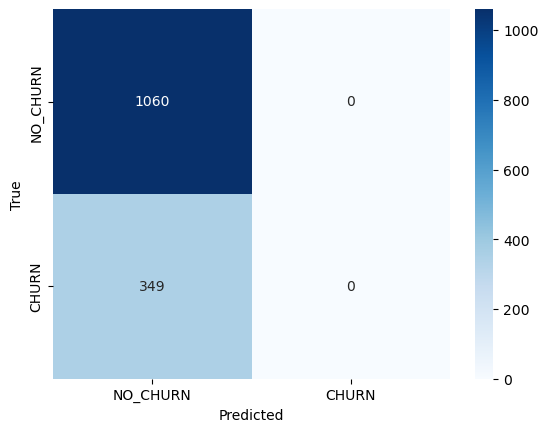

In [ ]:
#prédiction
y_pred = []
y_true = [1 if label == "Yes" else 0 for label in train_val["test"]["Churn"]]
X_test = train_val["test"].remove_columns('Churn') #supprimer pour pas lui montré
for y in tqdm(X_test):
  y_pred_unit = ask_gpt(row_to_text(y), model, tokenizer)
  y_pred.append(y_pred_unit["CHURN"])

print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["NO_CHURN", "CHURN"]))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NO_CHURN", "CHURN"],
            yticklabels=["NO_CHURN", "CHURN"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Résultat :
On voit que le LLM de base ne sait pas comment les classer et qu'il va falloir le finetuné pour qu'ils puisse être utile.

Remarque avant de finetune un LLM peut être testé des modèles plus simple car peut être overkill le LLM pour faire ça.

### Finetuning
Pour faire du finetuning, il faut d'abord adapter notre dB pour qu'elle soit donné au modèle. L'idée c'est d'écrire que toutes les instruction, suivi des données suivie du résultat.

Remarque, ici ne mets pas la réponse car il va falloir définir un mask càd ce que le LLM peut lire et ce qu'il va devoir prédire. Plus simple de garder réponse à côté pour mettre mask à -100 pour dire que lit juste mais ne prédit pas et le reste du mask laisse à l'Id du token.

Alors faire attention à ce que j'ai écrit ici au dessus pas vrai.
le mask c'est pour faire du padding pour toujours avoir la même longueur pour plus opti à stocker et pour carte graphique ainsi mets 0 pour rajoute padding qui veux rien dire. avec le -100 c'est dans labels par dans attention mask.

Va aussi regarder que chaque querry à la même longueur ainsi sera plus simple avec batch et la attention mask utile pour dire ou la padding s'arrête

In [6]:
def row_to_prompt(row, add_ans=True):
    text = "### Instruction:\n"
    text += "Prédire si ce client churnera ou non.\n\n"
    text += "### Données du client:\n"
    for col, val in row.items():
        if col != "Churn":
            text += f"{col}: {val}\n"
    if add_ans:
        text += "\n### Réponse:\n"
    return text


def format_for_llm(example):
    prompt = row_to_prompt(example) #transforme en beau prompt

    answer = "CHURN" if example["Churn"] == "Yes" else "NO_CHURN" #ajout CHURN ou NO_CHURN selon la colonne Churn pour que le LLM doivent arrive rà la prédire

    full_text = prompt + answer

    tokenized = tokenizer( #va tout tokenizer le prompt + answer
        full_text,
        truncation=True,
        max_length=180,
        # padding="max_length"
    )

    true_lenght = sum(tokenized["attention_mask"]) #longueur du prompt seulement
    
    labels = [-100] * len(tokenized["attention_mask"]) #mets tout à -100 et le fait sur longuer d'attention mask qui fait toujours max_lenght vu la config

    answer_ids = tokenizer(answer, add_special_tokens=False)["input_ids"] #tokeninze que la réponse pour savoir le combien de token à la fin faut prédire 
    k = len(answer_ids)

    # remet dans le mask les numéro des dernier token à prédire
    labels[true_lenght-k:true_lenght] = answer_ids #ATTENTION comme mits padding faut retrouver la fin avant le padding pour ça regarder attention mask

    assert len(labels) == len(tokenized["attention_mask"]), f"{len(labels)} != {len(tokenized['attention_mask'])}" #vérif que même taille

    # print(len(tokenized["input_ids"]), len(tokenized["attention_mask"]), len(labels)) #debug

    tokenized["labels"] = labels #le mets proprement comme mask nommé "labels"
    return tokenized

#créer un datset en prennat dataset et appliquant le formatage d'avant et supprimer les colonnes d'origine
tokenized_dataset = dataset.map( #applique sur tout le dataset donc y compris avec le split train et test
    format_for_llm, 
    remove_columns=dataset["train"].column_names
)

print(tokenized_dataset) #verif si les 3 ensemble sont bien passé

Map:   0%|          | 0/4225 [00:00<?, ? examples/s]

Map:   0%|          | 0/1409 [00:00<?, ? examples/s]

Map:   0%|          | 0/1409 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 4225
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1409
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 1409
    })
})


In [6]:
#verification des longueur max de token
m = 0
l = 0
i = 0

aa = ["train", "test"]
for type in aa:
    for d in range(len(tokenized_dataset[type])):
        actuel = len(tokenized_dataset[type][d]['attention_mask'])
        if  actuel > m:
            m = actuel
        actuel = len(tokenized_dataset[type][d]['labels'])
        if  actuel > l:
            l = actuel
        actuel = len(tokenized_dataset[type][d]['input_ids'])
        if  actuel > i:
            i = actuel
print("Max token length:", m)
print("Max labels length:", l)
print("Max input_ids length:", i)
#donc va mettre max padding à 180 ainsi tous auront la même taille pour faire batch sera plus simple et rapide (sans on 163 token max )

Max token length: 152
Max labels length: 152
Max input_ids length: 152


In [5]:

# sert pour fait batching si on a pas même longueur partout
# donc dans notre cas ne sert à rien et va prendre du temps pour rien.
# remarque j'ai l'impression que le garder on et pas limité la longueur de token donne au final meilleur résultat aucune idée pourquoi.
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    padding=True,
    return_tensors="pt"
)

#ajout de param en suivant du Low rank adaptation
lora_config = LoraConfig(
    r=8, #rang que rajoute
    lora_alpha=16, #impact du lora en gros on lora_alpha / r = scaling factor et ça donne à quel point impact
    lora_dropout=0.05, #dropout classic
    bias="none", #train pas non plus biais
    target_modules=["q_proj", "v_proj"], #pour que avoir matrice Q et V dans attention
    task_type="CAUSAL_LM", #pour dire prédiction du prochain token
)

model = get_peft_model(model, lora_config) #va freeze param de départ et ajouter les param lora
model.print_trainable_parameters()   # affiche le nombre qu'on peut train et la doit être petit genre dans les millions pas milliards comme le modèle de base a

# 4. Construire Trainer
training_args = TrainingArguments(
    output_dir="./llama_churn_lora",
    per_device_train_batch_size=2,  # batch size par gpu
    gradient_accumulation_steps=8, # attend 8 étape donc 16 gradient pour faire loss
    learning_rate=2e-4, # learning rate pour lora souvent entre 1e-4 et 3e-4
    num_train_epochs=3, #nombre d'époque
    logging_steps=10, #tout le comibne crée un log
    fp16=True, #précision et pas FP32 pour pas prendre trop de VRAM
    save_strategy="epoch", #quand sauvegarde
    eval_strategy="epoch", #pour voir à quel point loss diminue sur eval_dataset
    #force à reload le meilleur à la fin
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss", #suit métrique de validation
    # greater_is_better=False, #prend le plus petit
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"], 
    # data_collator=default_data_collator
    data_collator=data_collator # on a quand même besoin d'un datacollector pour mettre dans le batch et gérait la fin d'une époche mais ça peut peut prendre default_dat_collector qui est déjà mis par défaut comme argument dans Trainer
)


# lance l'entraînement
trainer.train()

# Sauvegarde du modèle entraîné dans un emplacement séparé
model.save_pretrained("./best_trained_llama_churn_lora")
tokenizer.save_pretrained("./best_trained_llama_churn_lora")


trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


Epoch,Training Loss,Validation Loss
1,0.208500,0.181945
2,0.148900,0.152817
3,0.167800,0.152574


('./best_trained_llama_churn_lora/tokenizer_config.json',
 './best_trained_llama_churn_lora/special_tokens_map.json',
 './best_trained_llama_churn_lora/chat_template.jinja',
 './best_trained_llama_churn_lora/tokenizer.json')

### Test
Maintenant qu'on a train le modèle, on va le restester comme avant.

On va juste recharcher le modèle si pas définit. Va d'abord utiliser le même templace qu'on a utilisé pour le train pour dans les meilleurs conditions. Juste doit retokenizé car avant avait réponse de dans et ici ne va plus le mettre.

Attention ne surtout pas faire ça jsp pourquoi mais déjà que fait ça et reload le model devient très très mauvais.

In [3]:
#load model si encore en mémoire le mets dans model
if 'trainer' in globals() and hasattr(trainer, 'model'):
    pass #surtout pas prendre trainer.model devrait être best mais remarque que capacité du modèle tombe à rien
else: #sinon reload tout
    
    bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
    )


    #charge modèle
    model = AutoModelForCausalLM.from_pretrained(
        "./best_trained_llama_churn_lora",
        quantization_config=bnb_config,
        trust_remote_code=True,
        device_map="auto"
    )
    tokenizer = AutoTokenizer.from_pretrained("./best_trained_llama_churn_lora")
    tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
def predict_churn(sample):
    prompt = row_to_prompt(sample, False) #pas besoin de supprimer churn déjà prévu dans la fonction donc peut le garder dans le dataset de test

    # print(prompt)

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=180
    ).to(model.device)


    for i in range(8):
        with torch.no_grad():
            output = model.generate(
                **inputs,
                max_new_tokens=3,
                pad_token_id=tokenizer.eos_token_id
            )

        text = tokenizer.decode(output[0][len(inputs[0]):], skip_special_tokens=True)
        text = text.lower()

        # print(text)

        if "no" in text:
            return 0, False
        elif "churn" in text and "no" not in text: #mets check pour dire que si ya _ devient tendu de pouvoir dire que c'était bien churn
            return 1, False
    
    return 0, True #renvoie false si a foiré


100%|██████████| 1409/1409 [03:07<00:00,  7.50it/s]


Failled 0.00%
Accuracy: 0.6955287437899219

Classification report:
              precision    recall  f1-score   support

    NO_CHURN       0.81      0.78      0.80      1060
       CHURN       0.39      0.42      0.41       349

    accuracy                           0.70      1409
   macro avg       0.60      0.60      0.60      1409
weighted avg       0.70      0.70      0.70      1409



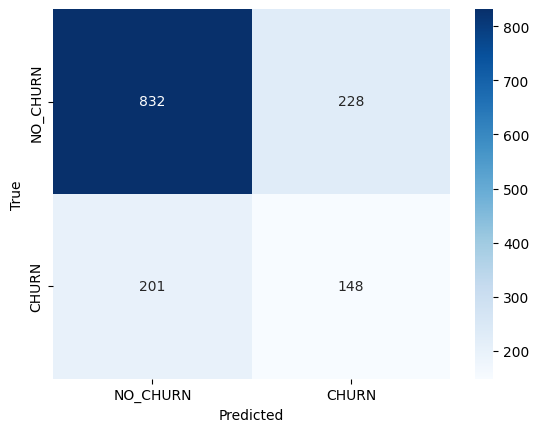

In [9]:
failed = 0
y_pred = []
y_true = [1 if label == "Yes" else 0 for label in dataset["test"]["Churn"]] #convertit en bool le yes et no

c=0
for elem in tqdm(dataset["test"]):
  pred, fail = predict_churn(elem)  
  y_pred.append(pred) #ajoute au fur et à mesur remarque vav être long car peut retester beaucoup de fois et pas de sécurité pour l'instant
  if fail:
    failed +=1
  # if c>10:
  #   break
  c+=1
  

print(f"Failled {failed/len(y_pred)*100:.2f}%")

# #regarde valeur des métriques
print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["NO_CHURN", "CHURN"]))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NO_CHURN", "CHURN"],
            yticklabels=["NO_CHURN", "CHURN"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Remarque :
si on tante sans split train, validation, test peuta voir un peu meilleur mais préfère suivre les bonnes pratiques.

### Autre test
Je vais également essayer avec une autre format de promte qu'on avait essayé avant pour voir si les résultats suivent toujours la même chose.

  0%|          | 0/1409 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128009 for open-end generation.
100%|██████████| 1409/1409 [07:38<00:00,  3.07it/s]

Accuracy: 0.752306600425834

Classification report:
              precision    recall  f1-score   support

    NO_CHURN       0.75      1.00      0.86      1060
       CHURN       0.00      0.00      0.00       349

    accuracy                           0.75      1409
   macro avg       0.38      0.50      0.43      1409
weighted avg       0.57      0.75      0.65      1409




/home/etudiant6/conda_envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/etudiant6/conda_envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/etudiant6/conda_envs/myenv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capita

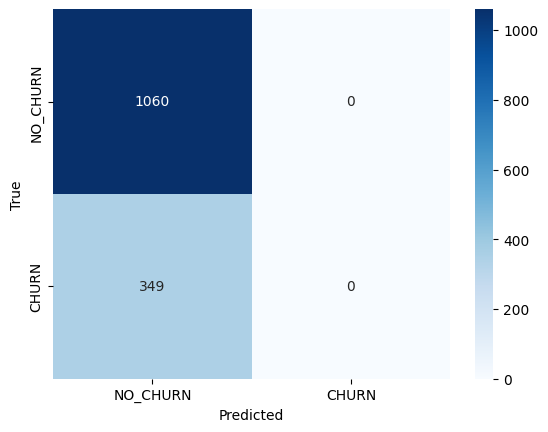

In [14]:
y_pred = []
y_true = [1 if label == "Yes" else 0 for label in dataset["test"]["Churn"]]
X_test = dataset["test"].remove_columns('Churn') #supprimer pour pas lui montré
for y in tqdm(X_test):
  y_pred_unit = ask_gpt(row_to_text(y), model, tokenizer)
  y_pred.append(y_pred_unit["CHURN"])

print("Accuracy:", accuracy_score(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["NO_CHURN", "CHURN"]))

cm = confusion_matrix(y_true, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["NO_CHURN", "CHURN"],
            yticklabels=["NO_CHURN", "CHURN"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#### Remarque :
On voit que si on utilise pas le même template arrive pas à prédire ce qui est normale car le modèle ne réfléchit pas, il fait que apprendre et il essaye de suivre la même structure.